# Extra Code Storage Notebook

I'll use this notebook to store code that is messy / that I'm messing with in the lead-up to the completion of the full materials. Will likely delete this notebook once the code is complete. 

### Inferential Stats and Visualizations.

Now that we have gleaned some insights from our EDA, it's time to explore some statistical tests to better probe the differences between DTI in January vs. December 2017.

The below code shows an example of how our understanding of the distribution of the mean of a population changes with how much we sample from it. In the bootstrap_mean function we randomly pull with replacement from our two distributions with a varying number of size n. When n is very small we see a large spread in the means of the distribution (with of n of 1 looking almost identical to our original distribution). As we increase n our measurement of the mean becomes more normal. As n becomes very large we start having a very deep understanding of the uncertainty in the mean of our distributions.

In [11]:
dti_df_t = dti_df.dropna()
A = dti_df_t.loc[dti_df.orig_dte==dti_df.orig_dte.unique()[0], 'dti']
B = dti_df_t.loc[dti_df.orig_dte==dti_df.orig_dte.unique()[1], 'dti']

def bootstrap_means(dti_df, n,  N):
    _a = dti_df.orig_dte.unique()[0]
    _b = dti_df.orig_dte.unique()[1]
    a = dti_df.loc[dti_df.orig_dte == _a, 'dti']
    b = dti_df.loc[dti_df.orig_dte == _b, 'dti']
    # taking the mean of a radnom subset of sie n of each sample. Doing this N times for a and b
    mean_a = [np.mean(np.random.choice(a,size = n, replace = True)) for i in range (N)]
    mean_b = [np.mean(np.random.choice(b,size = n, replace = True)) for i in range (N)]
    diff_a_b = [i-j for i, j in zip(mean_a, mean_b)]
    
    return [
        pd.DataFrame(data={'mean' : mean_a , 'diff' : diff_a_b, 'n' : [str(n)] * N, 'label' : _a }),
        pd.DataFrame(data={'mean' : mean_b , 'diff' : diff_a_b, 'n' : [str(n)] * N, 'label' : _b })
    ]

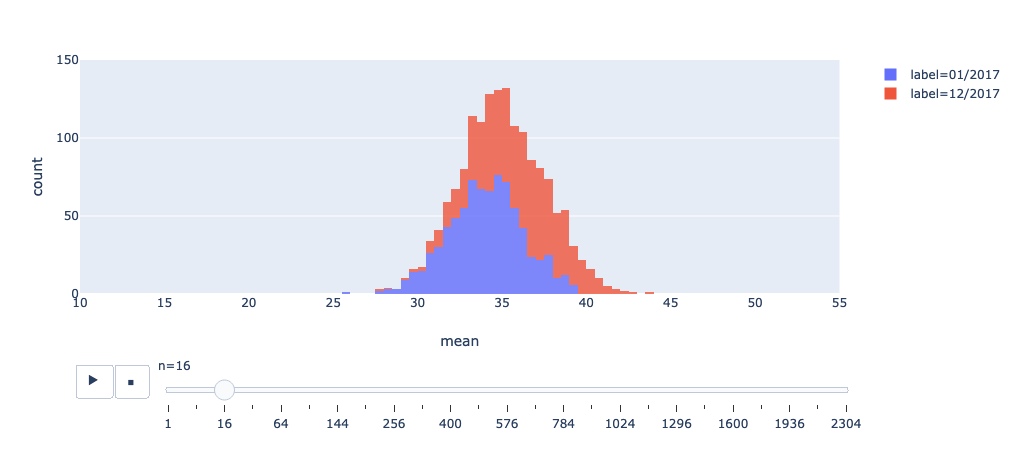

In [12]:
df_list = []
# I am looping through different boostrapping parameters for a visual
for i in range(0,50,2):
    if i == 0: i = 1
    df_list += bootstrap_means(dti_df_t,
                               i*i, # using i^2 because a linear scale change is not as descriptive
                               800)
    
data = pd.concat(df_list).reset_index()
p = px.histogram(data, x='mean',
                 color = 'label',
                 opacity=.8,
                 animation_frame='n',
                 nbins=40,
                 #marginal='violin',
                 range_y = [0,150],
                 range_x = [10,55]
                )

p

The sampling approach we took above should give some intuitive sense that the two distributions have different means. We can prove this with a paired statistical test. We could also substract the two distributions and test if the new distribution has a mean of zero.

In [13]:
# to-do here: run a KS test to test the difference between both distributions

Below we compare the two distrobutions in a more thorough manner. The t test may not necessarily work in this instance. Here is a good resource to learn more optoins https://scipy-lectures.org/packages/statistics/index.html

Check for equal variances: LeveneResult(statistic=364.1337154683792, pvalue=4.374068917592142e-81)
Check for normality (0.9656326174736023, 0.0)
Results of t-test Ttest_indResult(statistic=-28.10645738472367, pvalue=2.189027962821834e-173)
Results of wilcoxon WilcoxonResult(statistic=149802391.0, pvalue=4.2571602774699444e-88)
Results of Mann–Whitney U test MannwhitneyuResult(statistic=1572829022.5, pvalue=1.8957012816125667e-202)
-1.6329705082003383


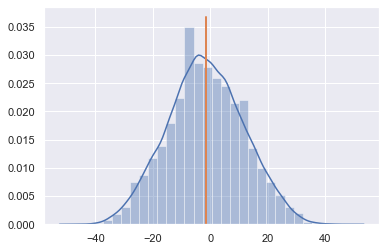

In [14]:
from scipy import stats
# Homogeneity of variances is required for t-tests
print("Check for equal variances: " + str(stats.levene(A, B)))
# These two distros do not have homogeneity of variances. 
print("Check for normality " + str(stats.shapiro(A)))
# Running the t-test anyway, despite it's assumptions being violated.
print("Results of t-test " + str(stats.ttest_ind(A,B)))

# Wilcoxon is a non paremetric test which measure sthe difference in means of paired points we are sampling.
# Wilcoxon tests if the difference in means is zero for a number of points. We need equal length samples
A_samp = np.random.choice(A,size = min(len(A), len(B)))
B_samp = np.random.choice(B,size =  min(len(A), len(B)))
print("Results of wilcoxon " + str(stats.wilcoxon(A_samp, B_samp)))
# This test is even better with our data set. Similar to the above test, but works with large groups
print("Results of Mann–Whitney U test " + str(stats.mannwhitneyu(A, B)))

# Below we can visualize the wilcoxon result
mean_ = np.mean(A_samp-B_samp) # Finding th mean of the differences
_ = sns.distplot(A_samp-B_samp, bins=30) # Plotting the distribution
plt.plot([mean_, mean_], [ 0,_.get_ybound()[1]], linewidth=2) # Adding a line for the mean
print(mean_)


Ks_2sampResult(statistic=0.13024931970287557, pvalue=8.755310974720224e-201)

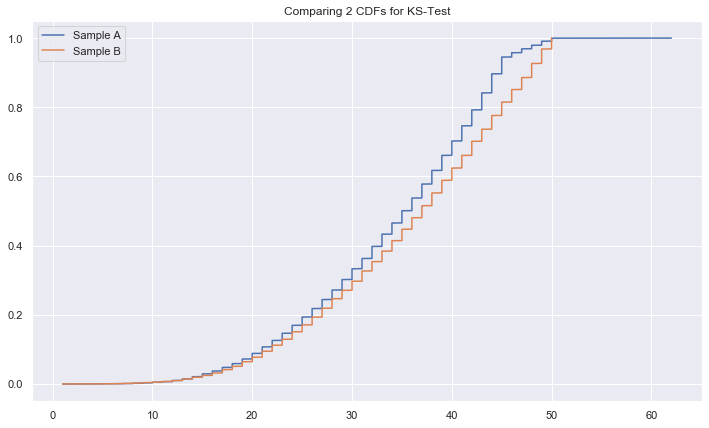

In [15]:
# Plot the CDFs
def ks_plot_comp(data_1, data_2, name1='data1', name2='data2'):
    '''
    Data entereted must be the same size.
    '''
    length = len(data_1)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(data_1), np.linspace(0, 1, len(data_1), endpoint=False))
    plt.plot(np.sort(data_2), np.linspace(0, 1, len(data_2), endpoint=False))
    plt.legend('top right')
    plt.legend([name1, name2])
    plt.title('Comparing 2 CDFs for KS-Test')
    
    
ks_plot_comp(A_samp, B_samp, name1='Sample A', name2= 'Sample B')
# Testing is these are of the same distribution
stats.ks_2samp(A_samp, B_samp)